### Patrick Horlaville (260931235) - Problem Set 5 - PHYS 512 : Computational Physics with Applications

Prof: Jon Sievers. TAs: Marcus Merryfield, Rigel Zifkin, Daniel Coelho

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import camb

Here I use the script from planck_likelihood.py in the mcmc directory, but it needs a slight adjustment for an arbitrary number of points for our spectrum:

In [3]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars, npts, lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2: npts + 2]

## Problem 1

First, we compute the CMB spectrum with the initial set of parameters from the test script, and we look at the resulting $\chi^2$

In [4]:
planck = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows = 1)
spec = planck[:,1]
errs = 0.5*(planck[:,2] + planck[:,3])
npts = len(spec)
nparams = 6
Ninv = np.eye(npts)/(errs**2)

In [5]:
params_test = np.array([60, 0.02, 0.1, 0.05, 2.00e-9, 1.0])
model_test = get_spectrum(params_test, npts)
res_test = spec - model_test
chisq_test = np.sum((res_test/errs)**2)
print("For the initial guess of parameters, χ2 =", chisq_test)

For the initial guess of parameters, χ2 = 15267.937968222595


In [6]:
params_better = np.array([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
model_better = get_spectrum(params_better, npts)
res_better = spec - model_better
chisq_better = np.sum((res_better/errs)**2)
print("With the more refined parameters, χ2 is now =", chisq_better)

With the more refined parameters, χ2 is now = 3272.2033778089576


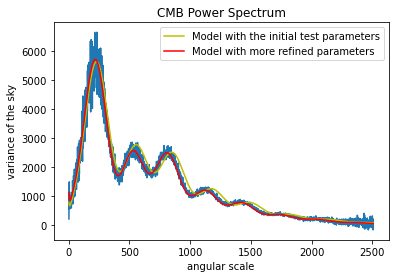

In [7]:
plt.plot(planck[:, 0], planck[:, 1])
plt.plot(planck[:, 0], model_test, 'y', label = 'Model with the initial test parameters')
plt.plot(planck[:, 0], model_better, 'r', label = 'Model with more refined parameters')
plt.xlabel('angular scale')
plt.ylabel('variance of the sky')
plt.title('CMB Power Spectrum')
plt.legend()

## Problem 2

Now we will use Levenberg-Marquardt to find the best-fit parameters of the cosmological model, using numerical derivatives. Firt we define the function to compute the numerical derivative. We take a step to be arbitrarily a 100th of each parameter's value, which should be of a reasonable order.

In [168]:
nparams = len(params_test)
print('All throughout, we will be dealing with', nparams, 'parameters for modelling the CMB power spectrum.')

All throughout, we will be dealing with 6 parameters for modelling the CMB power spectrum.


In [9]:
def get_deriv(pars, npts):
    
    deriv_mat = np.empty([npts, npars])
    
    for i in range(npars):
        
        h_arr = np.zeros(npars)
        h_arr[i] = 0.01*pars[i]
        
        deriv_mat[:, i] = (get_spectrum(pars + h_arr, npts) - get_spectrum(pars - h_arr, npts))/(2*h_arr[i])
    
    return deriv_mat

A few other functions are defined prior to defining the LM fit function, which are taken from class notes. update_lamda adjusts the step size, get_matrices yields different matrix elements that are needed to the LM fit process (including the $\chi^2$ between the data and each model) and linv inverts required specified matrix elements.

In [10]:
def update_lam(lam, yes):
    
    if yes: 
        lam = lam/1.5
        if lam < 0.5: 
            lam = 0
    else: 
        if lam == 0: 
            lam = 1
        else:
            lam = lam*1.5**2
            
    return lam

In [11]:
def get_mat(params, npts, N_inv):
    
    model = get_spectrum(params, npts)
    derivs = get_deriv(params, npts)
    
    res = spec - model
    
    lhs = derivs.T@N_inv@derivs
    rhs = derivs.T@N_inv@res
    chisq = res.T@N_inv@res
    
    return chisq, lhs, rhs

In [12]:
def linv(mat, lam):
    mat = mat + lam*np.diag(np.diag(mat))
    return np.linalg.inv(mat)

Now, we write the Levenberg-Marquardt fit. The covariance matrix is computed, which allows to compute the change in parameters. We compute the new $\chi^2$ and matrices elements from the updated parameters. If the $\chi^2$ decrease, from one step to another, is smaller than the threshold defined by chi_tol, the fit stops. If the number of steps are ran out, the fit stops. Otherwise, a new step is taken. If the $\chi^2$ increases, reject the step and take a new bigger one. Also, we apply a limit on some parameter values: I noticed there was an overflow if tau reached certain values. Some constraints alleviate this problem, such that if tau's new value reaches some interval, it is rejected.

In [109]:
def LM_fit(params, npts, N_inv, chi_tol, max_iter, params_prior = None, params_err = None):
    
    lam = 0
    chisq, lhs, rhs = get_mat(params, npts, N_inv)
    
    for i in range(max_iter):
        
        while True: 

            lhs_inv = linv(lhs, lam)

            dparams = lhs_inv@rhs
            
            if (params[3] + dparams[3] > 0.02) and (params[3] + dparams[3] < 0.1):
                break
            
            else:
                lam = update_lam(lam, False)

        
        chisq_new, lhs_new, rhs_new = get_mat(params + dparams, npts, N_inv)
        
        if params_prior is not None:
            trial_prior = prior_chisq(params + dparams, params_prior, params_err)
            chisq_new += trial_prior
        
        
        if chisq_new < chisq:
            
            if lam == 0.0:
                
                if (np.abs(chisq - chisq_new) < chi_tol):
                    return params + dparams, lhs_new
            
            chisq = chisq_new
            lhs = lhs_new
            rhs = rhs_new
            params = params + dparams
            lam = update_lam(lam, True)
        
        else: 
            lam = update_lam(lam, False)
        
    return params, lhs

The code is ran through 'PS5_code.py' and we load it here. Note: here we only perform 10 iterations for the LM fit and the MCMC. More steps were performed with the code 'PS5_code_lot.py', but it takes roughly 8 hours to run [compared to about 30 minutes for the former]

In [175]:
best_fit_params, err_params = np.loadtxt('Results/planck_fit_params.txt')

In [176]:
H0, ombh2, omch2, tau, As, ns = best_fit_params
err0, err1, err2, err3, err4, err5 = err_params
print('Best fit parameters found with the LM fit are:')
print('H0 =', round(H0), '(+/-)', round(err0))
print('ΩBh² =', round(ombh2, 4), '(+/-)', round(err1, 4))
print('ΩCh² =', round(omch2, 3), '(+/-)', round(err2, 3))
print('τ =', round(tau, 2), '(+/-)', round(err3, 2))
print('As =', round(As, 10), '(+/-)', round(err4, 10))
print('ns =', round(ns, 3), '(+/-)', round(err5, 3))

Best fit parameters found with the LM fit are:
H0 = 68 (+/-) 1
ΩBh² = 0.0223 (+/-) 0.0002
ΩCh² = 0.118 (+/-) 0.003
τ = 0.04 (+/-) 0.04
As = 2e-09 (+/-) 1e-10
ns = 0.972 (+/-) 0.006


## Problem 3

Now, we will perform a similar task to find more refined cosmological parameters, but using a Monte-Carlo Markov Chain (MCMC). To do so, we first generate a random step from our curvature matrix found before. We find the corresponding parameters' evolution, which yields a new $\chi^2$. The step is accepted on a stochastic basis. Then, the process repeats itself, with the updated (or not) parameters. Just as for our LM fitter, if tau reaches unphysical values (which overflow the CPU), the step is rejected.

In [68]:
def get_chisq(params, noise = errs):
    
    model = get_spectrum(params, npts)
    res = spec - model
    chisq = np.sum((res/noise)**2)
    
    return chisq

In [75]:
def MCMC(params, curv, nsteps, noise = errs, params_prior = None, params_err = None):
    
    chi_cur = get_chisq(params, noise)
    
    chain = np.zeros([nsteps, nparams])
    chi_vec = np.zeros(nsteps)
    
    counts = 0
    
    cholesky_mat = np.linalg.cholesky(curv)
    
    for i in range(nsteps):
            
        while True: 
            
            dparams = cholesky_mat@np.random.randn(nparams)

            if (params[3] + dparams[3] > 0.02) and (params[3] + dparams[3] < 0.1):
                break
        
        trial_params = params + dparams
        trial_chisq = get_chisq(trial_params, noise)
        
        if params_prior is not None: 
            trial_chisq += prior_chisq(trial_params, params_prior, params_err)
            
        dchisq = trial_chisq - chi_cur
        
        prob_accept = np.exp(-0.5*dchisq)
        accept = np.random.rand(1) < prob_accept
        
        if accept: 
            counts +=1
            params = trial_params
            chi_cur = trial_chisq
            
        
        chain[i,:] = params
        chi_vec[i] = chi_cur
            
    return chain, chi_vec 

In [80]:
data = np.loadtxt('Results/planck_chain.txt').T
chisq = data[0,:]
H0 = data[1, :]
omega_bh2 = data[2, :]
omega_ch2 = data[3,: ]
τ = data[4,: ]
A_s = data[5,: ]
n_s = data[6, :]

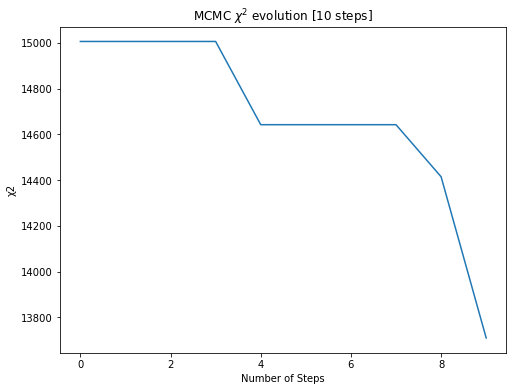

In [179]:
plt.figure(figsize = (8,6))
plt.plot(chisq)
plt.xlabel('Number of Steps')
plt.ylabel('χ2')
plt.title(r'MCMC $\chi^2$ evolution [10 steps]')
plt.show()

Here the $\chi^2$ decreases but does not stabilize. It's normal as we only did 10 steps! To see the result with 1000 steps, c.f. the section at the end: 'Lot of steps'

In [95]:
best_fit_params = np.mean(data[1::], axis = 1)
err_params = np.std(data[1::], axis = 1)

H0, ombh2, omch2, tau, As, ns = best_fit_params
err0, err1, err2, err3, err4, err5 = err_params
print('Best fit parameters found with the MCMC are:')
print('H0 =', round(H0), '(+/-)', round(err0))
print('ΩBh² =', round(ombh2, 5), '(+/-)', round(err1, 5))
print('ΩCh² =', round(omch2, 3), '(+/-)', round(err2, 3))
print('τ =', round(tau, 2), '(+/-)', round(err3, 2))
print('As =', round(As, 10), '(+/-)', round(err4, 10))
print('ns =', round(ns, 3), '(+/-)', round(err5, 3))

Best fit parameters found with the MCMC are:
H0 = 57 (+/-) 1
ΩBh² = 0.01997 (+/-) 4e-05
ΩCh² = 0.107 (+/-) 0.002
τ = 0.04 (+/-) 0.02
As = 2e-09 (+/-) 1e-10
ns = 0.991 (+/-) 0.003


We also want an estimate on $\Omega_\lambda$, which is, as cued by the problem statement, given by $1 - (\frac{100}{H_0}^2) \cdot (\Omega_b h^2 + \Omega_C h^2)$, from which we can also derive its error:

In [98]:
h = H0/100
omega_l = 1 - (ombh2 + omch2)/(h**2)
err_oml = omega_l*((ombh2/err1)**-2 + (omch2/err2)**-2 + 8*(err0/H0)**2)**(1/2)
print('Ωλ =', round(omega_l, 2), '(+/-)', round(err_oml, 2))

Ωλ = 0.62 (+/-) 0.02


## Problem 4

We now rerun the chain with a constraint on the optical depth $\tau$ as given by the problem statement. It is the only parameter that undergoes this prior, the others are let as they are. We also introduce a corresponding error on this prior. We modify the MCMC function to take that into account, by adding the prior_chisq function inside. Because we want a better estimate for the covariance matrix, we also run the LM fitter with the prior.

In [104]:
def prior_chisq(params, params_prior, params_err):
    params_shifted = params - params_prior 
    return np.sum((params_shifted/params_err)**2)

In [99]:
params_priors = np.array([0.0, 0.0, 0.0, 0.0540, 0.0, 0.0])
params_errs = np.zeros(nparams) + 1e20
params_errs[3] = 0.0074

Again, all is executed from 'PS5_code.py'. Here we load the results.

In [114]:
data_prior = np.loadtxt('Results/planck_chain_tauprior.txt').T
chisq = data[0,:]
H0 = data[1, :]
omega_bh2 = data[2, :]
omega_ch2 = data[3,: ]
τ = data[4,: ]
A_s = data[5,: ]
n_s = data[6, :]

What does the $\chi^2$ progression look like with this $\tau$ prior MCMC? [10 steps; for more, look in the next section]

Text(0, 0.5, 'χ2')

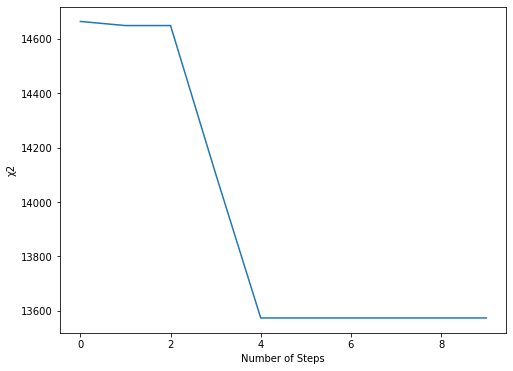

In [117]:
plt.figure(figsize = (8,6))
plt.plot(chisq)
plt.xlabel('Number of Steps')
plt.ylabel('χ2')

## Lot of steps

Loading data obtained with the fitters ran over a large amount of steps

Problem 2, LM with 100 iterations:

In [186]:
best_fit_params_lot, err_params_lot = np.loadtxt('Results_lot/planck_fit_params_lot.txt')

Problem 3, MCMC with 1000 iterations:

In [188]:
data_lot = np.loadtxt('Results_lot/planck_chain_lot.txt')

Problem 4, MCMC with 1000 iterations:

In [190]:
data_lot_prior = np.loadtxt('Results_lot/planck_chain_tauprior_lot.txt')

## Results

### Problem 2:

In [191]:
H0, ombh2, omch2, tau, As, ns = best_fit_params_lot
err0, err1, err2, err3, err4, err5 = err_params_lot
print('Best fit parameters found with the LM fit [100 iterations] are:')
print('H0 =', round(H0), '(+/-)', round(err0))
print('ΩBh² =', round(ombh2, 4), '(+/-)', round(err1, 4))
print('ΩCh² =', round(omch2, 3), '(+/-)', round(err2, 3))
print('τ =', round(tau, 2), '(+/-)', round(err3, 2))
print('As =', round(As, 10), '(+/-)', round(err4, 10))
print('ns =', round(ns, 3), '(+/-)', round(err5, 3))

Best fit parameters found with the LM fit [100 iterations] are:
H0 = 68 (+/-) 1
ΩBh² = 0.0223 (+/-) 0.0002
ΩCh² = 0.118 (+/-) 0.003
τ = 0.04 (+/-) 0.04
As = 2e-09 (+/-) 1e-10
ns = 0.972 (+/-) 0.006


### Problem 3

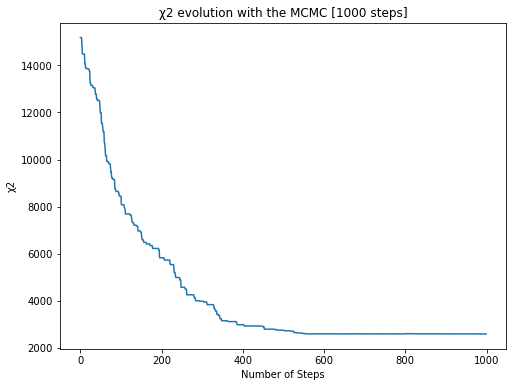

In [183]:
plt.figure(figsize = (8,6))
plt.plot(data_lot.T[0])
plt.xlabel('Number of Steps')
plt.ylabel('χ2')
plt.title('χ2 evolution with the MCMC [1000 steps]')
plt.show()

Now indeed, our $\chi^2$ stabilized! We can then say that our chain converged

### Problem 4

Text(0, 0.5, 'χ2')

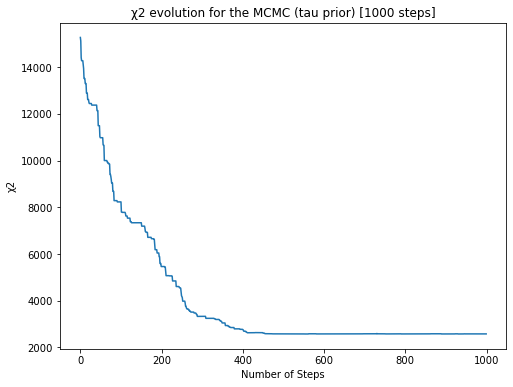

In [167]:
plt.figure(figsize = (8,6))
plt.plot(data_lot_prior.T[0])
plt.xlabel('Number of Steps')
plt.title('χ2 evolution for the MCMC (tau prior) [1000 steps]')
plt.ylabel('χ2')

The convergence of the chain is of very similar fashion as without the $\tau$ prior: it takes about 400 steps to reach stabilization, and $\chi^2$ stabilizes a little bit over 2000.

## Graphical Results

Here we show the CMB spectrum as found with the LM and MCMC methods without the $\tau$ prior, kind of as a conclusion to the assignment

In [230]:
params_LM = best_fit_params_lot
params_MCMC = data_lot[-1][1:7]

In [231]:
model_LM = get_spectrum(params_LM, npts)
model_MCMC = get_spectrum(params_MCMC, npts)

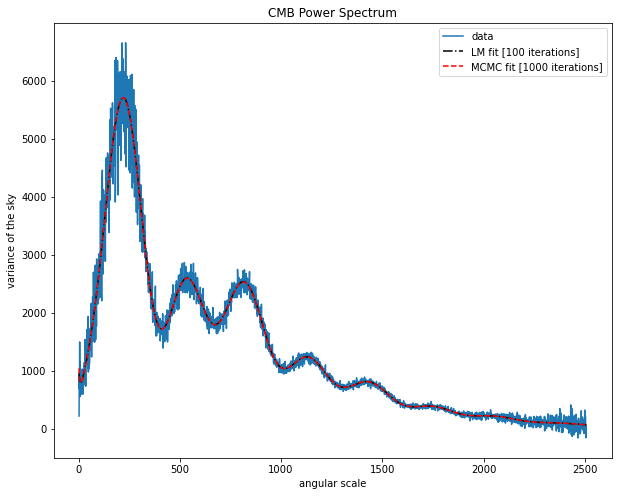

In [240]:
plt.figure(figsize = (10, 8))
plt.plot(planck[:, 0], planck[:, 1], label = 'data')
plt.plot(planck[:, 0], model_LM, 'k', linestyle = '-.', label = 'LM fit [100 iterations]')
plt.plot(planck[:, 0], model_MCMC, 'r', linestyle = '--', label = 'MCMC fit [1000 iterations]')
plt.xlabel('angular scale')
plt.ylabel('variance of the sky')
plt.title('CMB Power Spectrum')
plt.legend()

Both fits seem to be reasonable models for the data !